In [1]:
spark

StatementMeta(495bfb33-51fd-4c2c-8843-d4711866bbef, 4, 6, Finished, Available, Finished)

# AIO Machine Learning

In [19]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.sql.functions import when
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# File paths
file_path1 = "azureml://subscriptions/21ff0fc0-dd2c-450d-93b7-96eeb3699b22/resourcegroups/project-group-27/workspaces/project-group-27/datastores/workspaceblobstore/paths/UI/2024-12-08_211801_UTC/aio_labeled.csv"
file_path2 = "azureml://subscriptions/21ff0fc0-dd2c-450d-93b7-96eeb3699b22/resourcegroups/project-group-27/workspaces/project-group-27/datastores/workspaceblobstore/paths/UI/2024-12-07_201851_UTC/aio.csv"

# Read CSV files
df1 = spark.read.csv(file_path1, header=True, inferSchema=True, multiLine=True)
df2 = spark.read.csv(file_path2, header=True, inferSchema=True)

# Combine the two datasets
# df = df1.union(df2)
df = df1.join(df2, on="post_id", how="inner")

# StringIndexer to encode `overall_sentiment`
sentiment_indexer = StringIndexer(inputCol="overall_sentiment", outputCol="sentiment_index")

df = sentiment_indexer.fit(df).transform(df)

# Dropping the `post_id` column
df = df.drop("post_id", "overall_sentiment")

df = df.withColumn("final_label", 
                   when(df.final_label == "overreacting", 1)
                   .when(df.final_label == "not_overreacting", 0)
                   .otherwise(None))
df = df.withColumn("over_18", 
                   when(df.over_18 == "TRUE", 1)
                   .when(df.over_18 == "FALSE", 0)
                   .otherwise(None))

df = df.withColumn("score_post", col("score_post").cast("int"))
df = df.withColumn("num_comments", col("num_comments").cast("int"))

df = df.dropna(subset=["score_post", "num_comments", "sentiment_score", "nmf_topic", "over_18"])

# Data preview
df.show()

# Number of rows
num_rows = df.count()

# Number of columns
num_cols = len(df.columns)

# Print the shape
print(f"Shape: ({num_rows}, {num_cols})")


# Feature vector creation
feature_cols = [col for col in df.columns if col not in ["final_label", "sentiment_index", "subreddit_post", "post_title", "selftext", "created_date_post"]]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# RandomForest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="final_label", numTrees=100)

# Pipeline setup
pipeline = Pipeline(stages=[assembler, rf])

# Train-test split
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="final_label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

# Extract feature importances from the RandomForest model
rf_model = model.stages[-1]  # Last stage of the pipeline is the RandomForestClassifier
importances = rf_model.featureImportances

# Map feature importances to their corresponding column names
importance_dict = {feature: importance for feature, importance in zip(feature_cols, importances)}
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display feature importances
print("\nFeature Importances:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

StatementMeta(b1a6d09a-cd79-40bd-b154-9f59912128df, 1, 24, Finished, Available, Finished)

+-----------+---------------+--------------------+--------------------+----------+------------+-------+-----------------+---------------+---------+---------------+
|final_label| subreddit_post|          post_title|            selftext|score_post|num_comments|over_18|created_date_post|sentiment_score|nmf_topic|sentiment_index|
+-----------+---------------+--------------------+--------------------+----------+------------+-------+-----------------+---------------+---------+---------------+
|          1|AmIOverreacting|Boss said I dress...|I work as a socia...|         2|          33|      0|      2/2/24 1:42|     0.04347826|        1|            1.0|
|          0|AmIOverreacting|My dad walks away...|I need to know if...|       267|         172|      0|    2/20/24 22:55|    -0.22222222|        1|            0.0|
|          0|AmIOverreacting|  Am I overreacting?|I am 16, I live w...|        17|          26|      0|    2/25/24 18:08|            0.0|        5|            2.0|
|          0|AmI

In [20]:
from pyspark.ml.classification import GBTClassifier

# XGBoost Classifier (using Gradient Boosted Trees as an equivalent in Spark)
xgb = GBTClassifier(featuresCol="features", labelCol="final_label", maxIter=100)

# Add XGBoost to the pipeline
xgb_pipeline = Pipeline(stages=[assembler, xgb])

# Train the XGBoost model
xgb_model = xgb_pipeline.fit(train_data)

# Make predictions
xgb_predictions = xgb_model.transform(test_data)

StatementMeta(b1a6d09a-cd79-40bd-b154-9f59912128df, 1, 25, Finished, Available, Finished)

StatementMeta(b1a6d09a-cd79-40bd-b154-9f59912128df, 1, 26, Finished, Available, Finished)

Random Forest ROC AUC Score: 0.696078431372549
XGBoost ROC AUC Score: 0.6862745098039216


/tmp/ipykernel_9747/1863100645.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='#78C383')


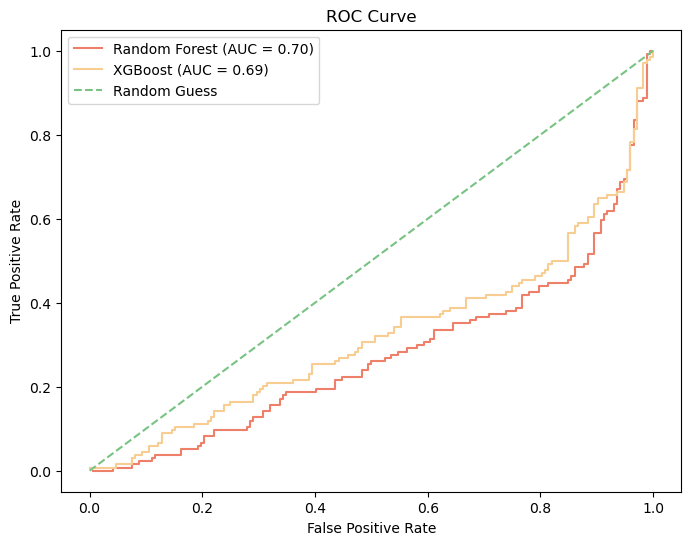

In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt

# Evaluate ROC AUC for both models
rf_auc = evaluator.evaluate(predictions)  # Random Forest
xgb_auc = evaluator.evaluate(xgb_predictions)  # XGBoost

print(f"Random Forest ROC AUC Score: {rf_auc}")
print(f"XGBoost ROC AUC Score: {xgb_auc}")

# ROC Curve for both models
rf_roc_data = predictions.select("probability", "final_label").rdd \
    .map(lambda row: (float(row.probability[1]), float(row.final_label))).collect()
xgb_roc_data = xgb_predictions.select("probability", "final_label").rdd \
    .map(lambda row: (float(row.probability[1]), float(row.final_label))).collect()

def compute_roc_curve(roc_data):
    roc_data = sorted(roc_data, key=lambda x: x[0])
    tprs, fprs = [], []
    positives = sum(1 for _, label in roc_data if label == 1)
    negatives = sum(1 for _, label in roc_data if label == 0)

    tp, fp = 0, 0
    for prob, label in roc_data:
        if label == 1:
            tp += 1
        else:
            fp += 1
        tprs.append(tp / positives)
        fprs.append(fp / negatives)

    return tprs, fprs

rf_tprs, rf_fprs = compute_roc_curve(rf_roc_data)
xgb_tprs, xgb_fprs = compute_roc_curve(xgb_roc_data)


# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(rf_fprs, rf_tprs, label=f'Random Forest (AUC = {rf_auc:.2f})', color='#EE7F68')
plt.plot(xgb_fprs, xgb_tprs, label=f'XGBoost (AUC = {xgb_auc:.2f})', color='#F8CD92')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='#78C383')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Make the background transparent
plt.gca().patch.set_alpha(0)  # Set axes background transparent
plt.savefig('roc_curve.png', transparent=True) 
plt.show()

StatementMeta(b1a6d09a-cd79-40bd-b154-9f59912128df, 1, 27, Finished, Available, Finished)

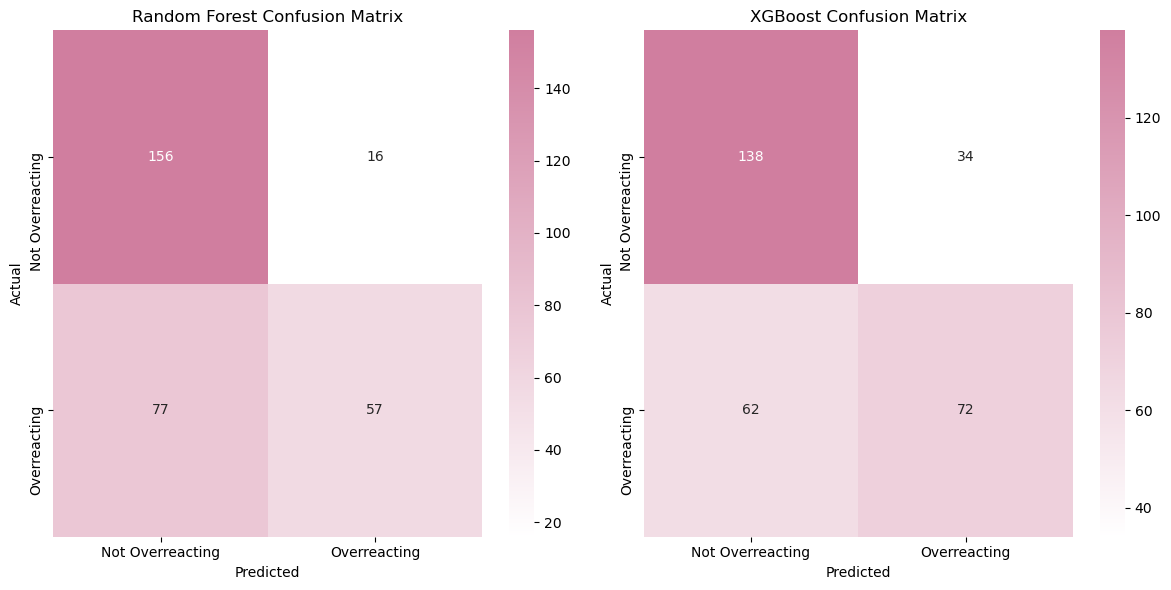

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["white", "#D07E9F"])

# Confusion Matrix for Random Forest
rf_y_true = predictions.select("final_label").rdd.flatMap(lambda x: x).collect()
rf_y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
rf_cm = confusion_matrix(rf_y_true, rf_y_pred)

# Confusion Matrix for XGBoost
xgb_y_true = xgb_predictions.select("final_label").rdd.flatMap(lambda x: x).collect()
xgb_y_pred = xgb_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
xgb_cm = confusion_matrix(xgb_y_true, xgb_y_pred)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(rf_cm, annot=True, fmt="d", cmap=custom_cmap, xticklabels=["Not Overreacting", "Overreacting"], yticklabels=["Not Overreacting", "Overreacting"], ax=axes[0])
axes[0].set_title("Random Forest Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(xgb_cm, annot=True, fmt="d", cmap=custom_cmap, xticklabels=["Not Overreacting", "Overreacting"], yticklabels=["Not Overreacting", "Overreacting"], ax=axes[1])
axes[1].set_title("XGBoost Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
# Make the background transparent
fig.patch.set_alpha(0)  # Set figure background transparent
plt.savefig('confusion_matrices.png', transparent=True) 
plt.show()

In [23]:
from sklearn.metrics import classification_report

# Precision, Recall, F1-Score for Random Forest
rf_report = classification_report(rf_y_true, rf_y_pred, target_names=["Not Overreacting", "Overreacting"])
print("Random Forest Classification Report:")
print(rf_report)

# Precision, Recall, F1-Score for XGBoost
xgb_report = classification_report(xgb_y_true, xgb_y_pred, target_names=["Not Overreacting", "Overreacting"])
print("XGBoost Classification Report:")
print(xgb_report)

StatementMeta(b1a6d09a-cd79-40bd-b154-9f59912128df, 1, 28, Finished, Available, Finished)

Random Forest Classification Report:
                  precision    recall  f1-score   support

Not Overreacting       0.67      0.91      0.77       172
    Overreacting       0.78      0.43      0.55       134

        accuracy                           0.70       306
       macro avg       0.73      0.67      0.66       306
    weighted avg       0.72      0.70      0.67       306

XGBoost Classification Report:
                  precision    recall  f1-score   support

Not Overreacting       0.69      0.80      0.74       172
    Overreacting       0.68      0.54      0.60       134

        accuracy                           0.69       306
       macro avg       0.68      0.67      0.67       306
    weighted avg       0.69      0.69      0.68       306



In [24]:
from sklearn.metrics import cohen_kappa_score

# Cohen's Kappa Score for Random Forest
rf_kappa = cohen_kappa_score(rf_y_true, rf_y_pred)
print(f"Random Forest Kappa Score: {rf_kappa}")

# Cohen's Kappa Score for XGBoost
xgb_kappa = cohen_kappa_score(xgb_y_true, xgb_y_pred)
print(f"XGBoost Kappa Score: {xgb_kappa}")

StatementMeta(b1a6d09a-cd79-40bd-b154-9f59912128df, 1, 29, Finished, Available, Finished)

Random Forest Kappa Score: 0.34994746219562345
XGBoost Kappa Score: 0.34766388346065025


In [9]:
# Number of rows
num_rows = df1.count()

# Number of columns
num_cols = len(df1.columns)

# Print the shape
print(f"Shape: ({num_rows}, {num_cols})")

StatementMeta(495bfb33-51fd-4c2c-8843-d4711866bbef, 3, 14, Finished, Available, Finished)

Shape: (11965, 9)


In [11]:
# Number of rows
num_rows = df.count()

# Number of columns
num_cols = len(df.columns)

# Print the shape
print(f"Shape: ({num_rows}, {num_cols})")

StatementMeta(495bfb33-51fd-4c2c-8843-d4711866bbef, 3, 16, Finished, Available, Finished)

Shape: (460, 11)


Feature importances analyses show that the score of the post is a deciding factor for predicting over_reacting/not_over_reacting. While topic categories contributes the least to the prediction. 

# AITA Machine Learning

In [1]:
file_path_aita_label = "azureml://subscriptions/21ff0fc0-dd2c-450d-93b7-96eeb3699b22/resourcegroups/project-group-27/workspaces/project-group-27/datastores/workspaceblobstore/paths/UI/2024-12-09_004445_UTC/aita_labels.csv"
file_path_aita_nlp = "azureml://subscriptions/21ff0fc0-dd2c-450d-93b7-96eeb3699b22/resourcegroups/project-group-27/workspaces/project-group-27/datastores/workspaceblobstore/paths/UI/2024-12-07_201851_UTC/aita.csv"
aita_df = spark.read.csv(file_path_aita_label, header=True, inferSchema=True, multiLine=True)


StatementMeta(b1a6d09a-cd79-40bd-b154-9f59912128df, 1, 6, Finished, Available, Finished)

In [2]:
from pyspark.sql import functions as F

# Step 2: Get the maximum `score_comment` for each `post_id`
max_score_df = aita_df.groupBy("post_id").agg(F.max("score_comment").alias("max_score_comment"))

# Step 3: Join this result back to the filtered DataFrame to get the rows with the highest `score_comment` per `post_id`
aita_df_filtered = aita_df.join(
    max_score_df,
    (aita_df.post_id == max_score_df.post_id) & (aita_df.score_comment == max_score_df.max_score_comment),
    "inner"
).select(aita_df["*"])  # Select all columns from the original DataFrame

# Step 1: Add columns for counts of each term
aita_df_with_counts = aita_df_filtered.withColumn("YTA_count", F.expr("size(split(comment_body, 'YTA')) - 1")) \
                                      .withColumn("NTA_count", F.expr("size(split(comment_body, 'NTA')) - 1")) \
                                      .withColumn("ESH_count", F.expr("size(split(comment_body, 'ESH')) - 1")) \
                                      .withColumn("NAH_count", F.expr("size(split(comment_body, 'NAH')) - 1")) \
                                      .withColumn("INFO_count", F.expr("size(split(comment_body, 'INFO')) - 1"))

# Step 2: Determine the label based on the highest count
aita_df_labeled = aita_df_with_counts.withColumn(
    "label",
    F.when(F.col("YTA_count") == F.greatest("YTA_count", "NTA_count", "ESH_count", "NAH_count", "INFO_count"), "YTA")
     .when(F.col("NTA_count") == F.greatest("YTA_count", "NTA_count", "ESH_count", "NAH_count", "INFO_count"), "NTA")
     .when(F.col("ESH_count") == F.greatest("YTA_count", "NTA_count", "ESH_count", "NAH_count", "INFO_count"), "ESH")
     .when(F.col("NAH_count") == F.greatest("YTA_count", "NTA_count", "ESH_count", "NAH_count", "INFO_count"), "NAH")
     .when(F.col("INFO_count") == F.greatest("YTA_count", "NTA_count", "ESH_count", "NAH_count", "INFO_count"), "INFO")
)

# aita_df_labeled.show()

StatementMeta(b1a6d09a-cd79-40bd-b154-9f59912128df, 1, 7, Finished, Available, Finished)

In [4]:
aita_df_labeled.count()

StatementMeta(495bfb33-51fd-4c2c-8843-d4711866bbef, 5, 9, Finished, Available, Finished)

215994

In [3]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.sql.functions import when
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

df_aita_nlp = spark.read.csv(file_path_aita_nlp, header=True, inferSchema=True)
df = aita_df_labeled.join(df_aita_nlp, on="post_id", how="inner")
df = df.select("score_post", "num_comments", "sentiment_score", "nmf_topic", "over_18", "label")
# df.show()

# StringIndexer to encode `overall_sentiment`
# sentiment_indexer = StringIndexer(inputCol="overall_sentiment", outputCol="sentiment_index")
label_indexer = StringIndexer(inputCol="label", outputCol="label_index")
# df = sentiment_indexer.fit(df).transform(df)
df = label_indexer.fit(df).transform(df)
# Dropping the `post_id` column
# df = df.drop("post_id", "overall_sentiment")

# df = df.withColumn("label", 
#                    when(df.label == "YTA", 0)
#                    .when(df.label == "NTA", 1)
#                    .when(df.label == "ESH", 2)
#                    .when(df.label == "NAH", 3)
#                    .when(df.label == "INFO", 4)
#                    .otherwise(None))
df = df.withColumn("over_18", 
                   when(df.over_18 == "TRUE", 1)
                   .when(df.over_18 == "FALSE", 0)
                   .otherwise(None))

df = df.withColumn("score_post", col("score_post").cast("int"))
df = df.withColumn("num_comments", col("num_comments").cast("int"))

df = df.dropna(subset=["score_post", "num_comments", "sentiment_score", "nmf_topic", "label_index"])

# # Data preview
# df.show()

# # Number of rows
# num_rows = df.count()

# # Number of columns
# num_cols = len(df.columns)

# # Print the shape
# print(f"Shape: ({num_rows}, {num_cols})")



StatementMeta(b1a6d09a-cd79-40bd-b154-9f59912128df, 1, 8, Finished, Available, Finished)

In [3]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.sql.functions import when
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

df_aita_nlp = spark.read.csv(file_path_aita_nlp, header=True, inferSchema=True)
df = aita_df_labeled.join(df_aita_nlp, on="post_id", how="inner")
df = df.select("score_post", "num_comments", "sentiment_score", "nmf_topic", "over_18", "label")
# df.show()

# StringIndexer to encode `overall_sentiment`
# sentiment_indexer = StringIndexer(inputCol="overall_sentiment", outputCol="sentiment_index")
label_indexer = StringIndexer(inputCol="label", outputCol="label_index")
# df = sentiment_indexer.fit(df).transform(df)
df = label_indexer.fit(df).transform(df)
# Dropping the `post_id` column
# df = df.drop("post_id", "overall_sentiment")

# df = df.withColumn("label", 
#                    when(df.label == "YTA", 0)
#                    .when(df.label == "NTA", 1)
#                    .when(df.label == "ESH", 2)
#                    .when(df.label == "NAH", 3)
#                    .when(df.label == "INFO", 4)
#                    .otherwise(None))
df = df.withColumn("over_18", 
                   when(df.over_18 == "TRUE", 1)
                   .when(df.over_18 == "FALSE", 0)
                   .otherwise(None))

df = df.withColumn("score_post", col("score_post").cast("int"))
df = df.withColumn("num_comments", col("num_comments").cast("int"))

df = df.dropna(subset=["score_post", "num_comments", "sentiment_score", "nmf_topic", "label_index"])

# Data preview
df.show()

# Number of rows
num_rows = df.count()

# Number of columns
num_cols = len(df.columns)

# Print the shape
print(f"Shape: ({num_rows}, {num_cols})")



StatementMeta(, , , Waiting, , Waiting)

+----------+------------+---------------+---------+-------+-----+
|score_post|num_comments|sentiment_score|nmf_topic|over_18|label|
+----------+------------+---------------+---------+-------+-----+
|         4|          26|           -0.2|        3|  false|  NTA|
|         0|          26|      0.6666667|        1|  false|  YTA|
|         0|          26|      0.6666667|        1|  false|  YTA|
|        90|          44|     0.14285715|        1|  false|  ESH|
|         7|          29|    -0.33333334|        1|  false|  NTA|
|       504|         253|    -0.33333334|        2|  false|  NTA|
|        19|          34|           -0.3|        3|  false|  YTA|
|        10|          27|     -0.3846154|        1|  false| INFO|
|        10|          30|            0.0|        2|  false|  NTA|
|      6184|        2216|         -0.375|        3|  false|  NTA|
|      6184|        2216|         -0.375|        3|  false|  ESH|
|         7|          32|           -0.6|        3|  false|  YTA|
|         

In [5]:
# Check the number of partitions
num_partitions = df.rdd.getNumPartitions()
print(f"Number of partitions: {num_partitions}")

StatementMeta(c8d5f074-6ca6-4bbb-bbf0-d4e3ba721f85, 0, 10, Finished, Available, Finished)

Number of partitions: 200


In [4]:
# Feature vector creation
feature_cols = [col for col in df.columns if col in ["score_post", "num_comments", "sentiment_score", "nmf_topic"]]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# RandomForest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label_index", numTrees=100)

# Pipeline setup
pipeline = Pipeline(stages=[assembler, rf])

# Train-test split
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

# Extract feature importances from the RandomForest model
rf_model = model.stages[-1]  # Last stage of the pipeline is the RandomForestClassifier
importances = rf_model.featureImportances

# Map feature importances to their corresponding column names
importance_dict = {feature: importance for feature, importance in zip(feature_cols, importances)}
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display feature importances
print("\nFeature Importances:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

StatementMeta(b1a6d09a-cd79-40bd-b154-9f59912128df, 1, 9, Finished, Available, Finished)

Test Accuracy: 0.6323606044815008

Feature Importances:
score_post: 0.7276101590599068
num_comments: 0.21593437237091181
sentiment_score: 0.03811727836869343
nmf_topic: 0.01833819020048804


In [5]:
from pyspark.ml.classification import OneVsRest, GBTClassifier

# Configure the base classifier
gbt = GBTClassifier(featuresCol="features", labelCol="label_index", maxIter=100)

# Wrap it with OneVsRest for multiclass classification
ovr = OneVsRest(classifier=gbt, labelCol="label_index", featuresCol="features")

# Create a pipeline with the OneVsRest classifier
xgb_pipeline = Pipeline(stages=[assembler, ovr])

# Train the OneVsRest (XGBoost-based) model
xgb_model = xgb_pipeline.fit(train_data)

# Make predictions with the OneVsRest model
xgb_predictions = xgb_model.transform(test_data)

StatementMeta(b1a6d09a-cd79-40bd-b154-9f59912128df, 1, 10, Finished, Available, Finished)

StatementMeta(b1a6d09a-cd79-40bd-b154-9f59912128df, 1, 12, Finished, Available, Finished)

/tmp/ipykernel_9747/2014263445.py:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='#78C383')


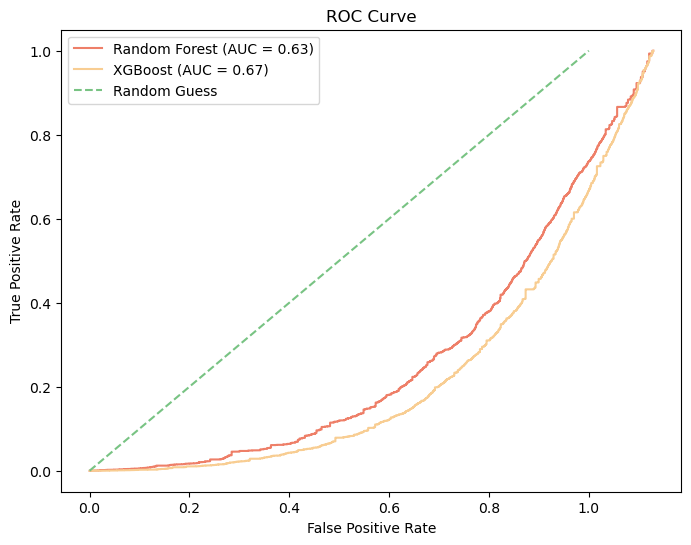

In [7]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np

# Evaluate ROC AUC for both models
rf_auc = evaluator.evaluate(predictions)  # Random Forest
xgb_auc = evaluator.evaluate(xgb_predictions)  # XGBoost

print(f"Random Forest ROC AUC Score: {rf_auc}")
print(f"XGBoost ROC AUC Score: {xgb_auc}")

# ROC Curve for both models
rf_roc_data = predictions.select("probability", "label_index").rdd \
    .map(lambda row: (float(row.probability[1]), float(row.label_index))).collect()
# Compute probabilities from rawPrediction for XGBoost
def raw_to_probability(raw_pred):
    exp_raw = np.exp(raw_pred)
    return exp_raw / exp_raw.sum()

# ROC Curve for XGBoost
xgb_roc_data = xgb_predictions.select("rawPrediction", "label_index").rdd \
    .map(lambda row: (float(raw_to_probability(row.rawPrediction)[1]), float(row.label_index))).collect()

def compute_roc_curve(roc_data):
    roc_data = sorted(roc_data, key=lambda x: x[0])
    tprs, fprs = [], []
    positives = sum(1 for _, label in roc_data if label == 1)
    negatives = sum(1 for _, label in roc_data if label == 0)

    tp, fp = 0, 0
    for prob, label in roc_data:
        if label == 1:
            tp += 1
        else:
            fp += 1
        tprs.append(tp / positives)
        fprs.append(fp / negatives)

    return tprs, fprs

rf_tprs, rf_fprs = compute_roc_curve(rf_roc_data)
xgb_tprs, xgb_fprs = compute_roc_curve(xgb_roc_data)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(rf_fprs, rf_tprs, label=f'Random Forest (AUC = {rf_auc:.2f})', color='#EE7F68')
plt.plot(xgb_fprs, xgb_tprs, label=f'XGBoost (AUC = {xgb_auc:.2f})', color='#F8CD92')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='#78C383')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Make the background transparent
plt.gca().patch.set_alpha(0)  # Set axes background transparent
plt.savefig('roc_curve.png', transparent=True) 
plt.show()

StatementMeta(b1a6d09a-cd79-40bd-b154-9f59912128df, 1, 15, Submitted, Running, Running)

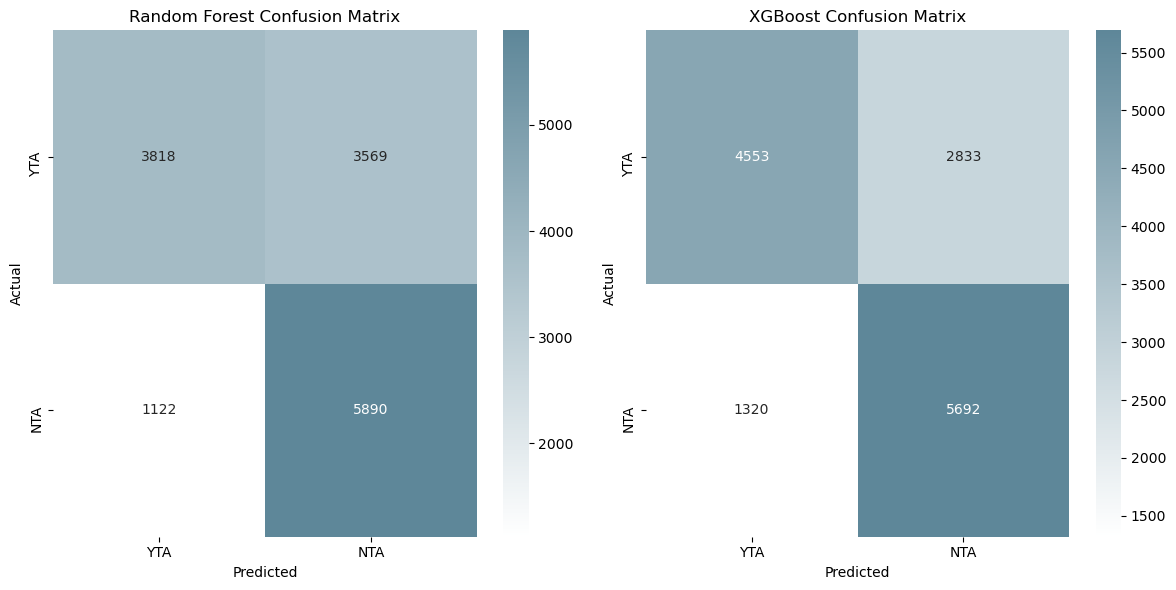

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap with #5E8799 as the main color
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["white", "#5E8799"])

# Confusion Matrix for Random Forest
rf_y_true = predictions.select("label_index").rdd.flatMap(lambda x: x).collect()
rf_y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
rf_cm = confusion_matrix(rf_y_true, rf_y_pred)

# Confusion Matrix for XGBoost
xgb_y_true = xgb_predictions.select("label_index").rdd.flatMap(lambda x: x).collect()
xgb_y_pred = xgb_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
xgb_cm = confusion_matrix(xgb_y_true, xgb_y_pred)
rf_cm = rf_cm[:2, :2]
xgb_cm = xgb_cm[:2, :2]

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(rf_cm, annot=True, fmt="d", cmap=custom_cmap, 
            xticklabels=["YTA", "NTA"], 
            yticklabels=["YTA", "NTA"], ax=axes[0])
axes[0].set_title("Random Forest Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(xgb_cm, annot=True, fmt="d", cmap=custom_cmap, 
            xticklabels=["YTA", "NTA"], 
            yticklabels=["YTA", "NTA"], ax=axes[1])
axes[1].set_title("XGBoost Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
# Make the background transparent
fig.patch.set_alpha(0)  # Set figure background transparent
plt.savefig('confusion_matrices.png', transparent=True) 
plt.show()

In [14]:
from sklearn.metrics import classification_report

# Precision, Recall, F1-Score for Random Forest
rf_report = classification_report(rf_y_true, rf_y_pred, target_names=["YTA", "NTA", "ESH", "NAH", "INFO"], zero_division=0)
print("Random Forest Classification Report:")
print(rf_report)

# Precision, Recall, F1-Score for XGBoost
xgb_report = classification_report(xgb_y_true, xgb_y_pred, target_names=["YTA", "NTA", "ESH", "NAH", "INFO"], zero_division=0)
print("XGBoost Classification Report:")
print(xgb_report)

StatementMeta(b1a6d09a-cd79-40bd-b154-9f59912128df, 1, 19, Finished, Available, Finished)

Random Forest Classification Report:
              precision    recall  f1-score   support

         YTA       0.72      0.52      0.60      7387
         NTA       0.59      0.84      0.69      7012
         ESH       0.00      0.00      0.00       383
         NAH       0.00      0.00      0.00       317
        INFO       0.00      0.00      0.00       253

    accuracy                           0.63     15352
   macro avg       0.26      0.27      0.26     15352
weighted avg       0.61      0.63      0.60     15352

XGBoost Classification Report:
              precision    recall  f1-score   support

         YTA       0.71      0.62      0.66      7387
         NTA       0.64      0.81      0.71      7012
         ESH       0.00      0.00      0.00       383
         NAH       0.00      0.00      0.00       317
        INFO       0.00      0.00      0.00       253

    accuracy                           0.67     15352
   macro avg       0.27      0.29      0.27     15352
weighted 

In [12]:
from sklearn.metrics import cohen_kappa_score

# Cohen's Kappa Score for Random Forest
rf_kappa = cohen_kappa_score(rf_y_true, rf_y_pred)
print(f"Random Forest Kappa Score: {rf_kappa}")

# Cohen's Kappa Score for XGBoost
xgb_kappa = cohen_kappa_score(xgb_y_true, xgb_y_pred)
print(f"XGBoost Kappa Score: {xgb_kappa}")

StatementMeta(, , , Waiting, , Waiting)

Random Forest Kappa Score: 0.3125477758880384
XGBoost Kappa Score: 0.37599140374591733


# Saving Models

In [17]:
# Save the trained Random Forest model
rf_model_path = "azureml://subscriptions/21ff0fc0-dd2c-450d-93b7-96eeb3699b22/resourcegroups/project-group-27/workspaces/project-group-27/datastores/workspaceblobstore/paths/UI/2024-12-08_211801_UTC/rf_model_aita"
model.write().overwrite().save(rf_model_path)
print(f"Random Forest model saved to {rf_model_path}")

StatementMeta(b1a6d09a-cd79-40bd-b154-9f59912128df, 1, 22, Finished, Available, Finished)

Random Forest model saved to azureml://subscriptions/21ff0fc0-dd2c-450d-93b7-96eeb3699b22/resourcegroups/project-group-27/workspaces/project-group-27/datastores/workspaceblobstore/paths/UI/2024-12-08_211801_UTC/rf_model_aita


In [18]:
# Save the trained XGBoost (OneVsRest) model
xgb_model_path = "azureml://subscriptions/21ff0fc0-dd2c-450d-93b7-96eeb3699b22/resourcegroups/project-group-27/workspaces/project-group-27/datastores/workspaceblobstore/paths/UI/2024-12-08_211801_UTC/xgboost_model_aita"
xgb_model.write().overwrite().save(xgb_model_path)
print(f"XGBoost model saved to {xgb_model_path}")

StatementMeta(b1a6d09a-cd79-40bd-b154-9f59912128df, 1, 23, Finished, Available, Finished)

XGBoost model saved to azureml://subscriptions/21ff0fc0-dd2c-450d-93b7-96eeb3699b22/resourcegroups/project-group-27/workspaces/project-group-27/datastores/workspaceblobstore/paths/UI/2024-12-08_211801_UTC/xgboost_model_aita
